In [67]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.sandwich_covariance import cov_hac
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [69]:
FEDFUNDS = pd.read_csv('FEDFUNDS_quarterly.csv') #independent variable
UNRATE = pd.read_csv('UNRATE_quarterly.csv')
CPIAUCSL = pd.read_csv('CPIAUCSL_quarterly.csv')
A229RX0 = pd.read_csv('A229RX0_quarterly.csv')
DRCCLACBS = pd.read_csv('DRCCLACBS.csv') # dependent variable 1 (delinq)
CORCCACBS = pd.read_csv('CORCCACBS.csv') # dependent variable 2 (charge-off)
GDPC1 = pd.read_csv('GDPC1.csv')

In [71]:
# adjust observation date to the first day of each quarter
obs_date = pd.to_datetime(FEDFUNDS['observation_date'])
obs_date = obs_date.dt.to_period('Q').dt.start_time
FEDFUNDS['observation_date'] = obs_date
UNRATE['observation_date'] = obs_date
CPIAUCSL['observation_date'] = obs_date
A229RX0['observation_date'] = obs_date

In [73]:
df_raw = pd.DataFrame()
df_raw['observation_date'] = obs_date
df_raw['FEDFUNDS'] = FEDFUNDS['FEDFUNDS']
df_raw['UNRATE'] = UNRATE['UNRATE']
df_raw['CPIAUCSL'] = CPIAUCSL['CPIAUCSL']
df_raw['A229RX0'] = A229RX0['A229RX0']
df_raw['DRCCLACBS'] = DRCCLACBS['DRCCLACBS']
df_raw['CORCCACBS'] = CORCCACBS['CORCCACBS']
df_raw['GDPC1'] = GDPC1['GDPC1']

In [75]:
# Stationarity check
for col in df_raw.columns[1:]:
    if adfuller(df_raw[col])[1]>0.05:
        print(col)

FEDFUNDS
CPIAUCSL
A229RX0
DRCCLACBS
GDPC1


In [77]:
# Transformation of non-stationary data
FEDFUNDS_diff = FEDFUNDS['FEDFUNDS'].diff().dropna()
logCPI = np.log(CPIAUCSL['CPIAUCSL'])
logCPI_diff = logCPI.diff().dropna()
logIncome = np.log(A229RX0['A229RX0'])
logIncome_diff = logIncome.diff().dropna()
Delinq_diff = DRCCLACBS['DRCCLACBS'].diff().dropna()
logGDP = np.log(GDPC1['GDPC1'])
logGDP_diff = logGDP.diff().dropna()

In [79]:
df_Delinq = pd.DataFrame()
df_Delinq['Delinq_diff'] = Delinq_diff
df_Delinq['FEDFUNDS_diff'] = FEDFUNDS_diff
df_Delinq['logCPI_diff'] = logCPI_diff
df_Delinq['logIncome_diff'] = logIncome_diff
df_Delinq['UNRATE'] = UNRATE['UNRATE'].iloc[1:]
df_Delinq['logGDP_diff'] = logGDP_diff

In [81]:
df_ChargeOff = pd.DataFrame()
df_ChargeOff['ChargeOff'] = CORCCACBS['CORCCACBS'].iloc[1:]
df_ChargeOff['FEDFUNDS_diff'] = FEDFUNDS_diff
df_ChargeOff['logCPI_diff'] = logCPI_diff
df_ChargeOff['logIncome_diff'] = logIncome_diff
df_ChargeOff['UNRATE'] = UNRATE['UNRATE'].iloc[1:]
df_ChargeOff['logGDP_diff'] = logGDP_diff

In [83]:
def local_projection(df, h = 1, p = 4, target = 'FEDFUNDS_diff'):
    df = df.copy()
  # Dependent variable, h-step ahead log change
    df['y_lead'] = df.iloc[:, [0]].shift(-h) - df.iloc[:, [0]]

    #Indepdent variable
    df['FEDFUNDS_diff'] = df['FEDFUNDS_diff']

    # Control variabels, CPI and RDPI growth rates
    # UNRATE does not use growth rates
    df['logCPI_diff'] = df['logCPI_diff']
    df['logIncome_diff'] = df['logIncome_diff']
    df['logGDP_diff'] = df['logGDP_diff']

    # Lag controls to t-1
    df['logCPI_diff_lag1'] = df['logCPI_diff'].shift(1)
    df['logIncome_diff_lag1'] = df['logIncome_diff'].shift(1)
    df['logGDP_diff_lag1']  = df['logGDP_diff'].shift(1)
    df['UNRATE_lag1'] = df['UNRATE'].shift(1)

    # Lags of delinq
    for j in range(1, p+1):
        df[f'y_lag{j}'] = df.iloc[:, [0]].shift(j)

    # Choose columns for regression
    cols_X = [target, 'UNRATE_lag1', 'logCPI_diff_lag1', 'logIncome_diff_lag1', 'logGDP_diff_lag1'] + [f'y_lag{j}' for j in range(1, p + 1)]

    model_df = df[['y_lead'] + cols_X].dropna()

    # Build design matrix
    y = model_df['y_lead']
    X = sm.add_constant(model_df[cols_X])

    model = sm.OLS(y, X).fit()

    # HAC/Newey-West SE for lag h
    cov = cov_hac(model, nlags = h)
    se = np.sqrt(np.diag(cov))

    # Extract coefficient and SE for target
    idx = list(X.columns).index(target)
    coef = model.params[target]
    tstat = coef/se[idx]

    return {
        "horizon": h,
        "coefficients": coef,
        "standard_errors": se[idx],
        "tstat": tstat,
        "observations_used": len(model_df),
        "model": model
    }

In [91]:
horizons = [1, 2, 3, 4]
results_Delinq = []

for h in horizons:
  res = local_projection(df_Delinq, h = h, p = 4)
  results_Delinq.append({
      "h": h,
      "coefficients": res["coefficients"],
      "standard_errors": res["standard_errors"],
      "tstat": res["tstat"],
  })

results_df_Delinq = pd.DataFrame(results_Delinq)
results_df_Delinq["CI_lower"] = results_df_Delinq["coefficients"] - 1.96 * results_df_Delinq["standard_errors"]
results_df_Delinq["CI_upper"] = results_df_Delinq["coefficients"] + 1.96 * results_df_Delinq["standard_errors"]
print(results_df_Delinq)

   h  coefficients  standard_errors     tstat  CI_lower  CI_upper
0  1      0.003553         0.044417  0.079994 -0.083504  0.090611
1  2      0.014098         0.055271  0.255078 -0.094233  0.122430
2  3     -0.008045         0.091758 -0.087677 -0.187890  0.171800
3  4     -0.007379         0.078528 -0.093971 -0.161294  0.146536


In [93]:
horizons = [1, 2, 3, 4]
results_ChargeOff = []

for h in horizons:
  res = local_projection(df_ChargeOff, h = h, p = 4)
  results_ChargeOff.append({
      "h": h,
      "coefficients": res["coefficients"],
      "standard_errors": res["standard_errors"],
      "tstat": res["tstat"],
  })

results_df_ChargeOff = pd.DataFrame(results_ChargeOff)
results_df_ChargeOff["CI_lower"] = results_df_ChargeOff["coefficients"] - 1.96 * results_df_ChargeOff["standard_errors"]
results_df_ChargeOff["CI_upper"] = results_df_ChargeOff["coefficients"] + 1.96 * results_df_ChargeOff["standard_errors"]
print(results_df_ChargeOff)

   h  coefficients  standard_errors     tstat  CI_lower  CI_upper
0  1     -0.207704         0.119272 -1.741428 -0.441477  0.026070
1  2     -0.311462         0.219033 -1.421988 -0.740767  0.117843
2  3     -0.556441         0.316064 -1.760533 -1.175927  0.063044
3  4     -0.625148         0.483035 -1.294209 -1.571895  0.321600


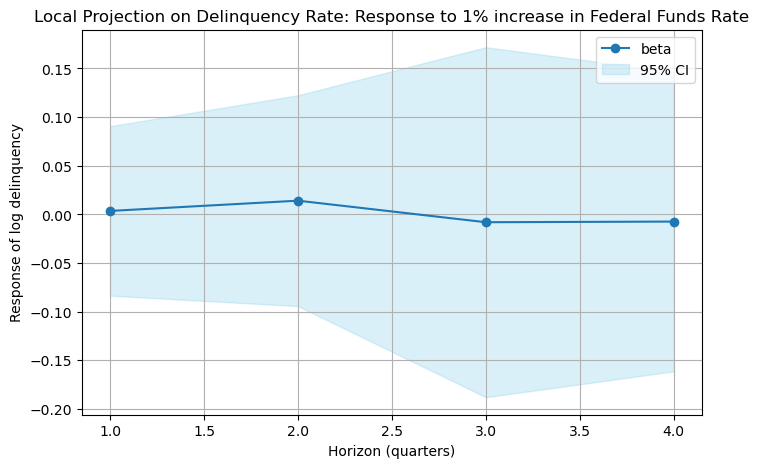

In [99]:
# Visualization of Beta_h with 95% Confidence Interval
plt.figure(figsize = (8,5))

plt.plot(results_df_Delinq["h"], results_df_Delinq["coefficients"], marker = "o", label = "beta")

plt.fill_between(
    results_df_Delinq["h"],
    results_df_Delinq["CI_lower"],
    results_df_Delinq["CI_upper"],
    color = "skyblue",
    alpha = 0.3,
    label = "95% CI"
)

for i, row in results_df_Delinq.iterrows():
  if abs(row["tstat"]) > 1.96:
    plt.text(row["h"], row["coefficients"], "*", fontsize = 14, ha = "center", va = "bottom")

plt.xlabel("Horizon (quarters)")
plt.ylabel("Response of log delinquency")
plt.title("Local Projection on Delinquency Rate: Response to 1% increase in Federal Funds Rate")
plt.legend()
plt.grid(True)
plt.savefig("localprojection_delinq.png")

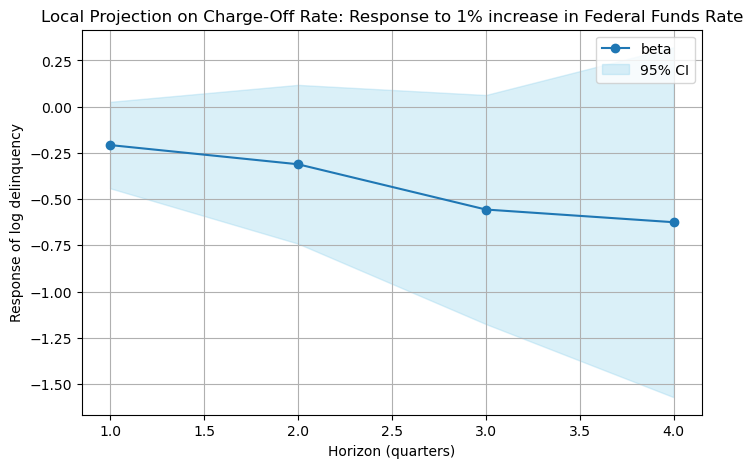

In [101]:
# Visualization of Beta_h with 95% Confidence Interval
plt.figure(figsize = (8,5))

plt.plot(results_df_ChargeOff["h"], results_df_ChargeOff["coefficients"], marker = "o", label = "beta")

plt.fill_between(
    results_df_ChargeOff["h"],
    results_df_ChargeOff["CI_lower"],
    results_df_ChargeOff["CI_upper"],
    color = "skyblue",
    alpha = 0.3,
    label = "95% CI"
)

for i, row in results_df_ChargeOff.iterrows():
  if abs(row["tstat"]) > 1.96:
    plt.text(row["h"], row["coefficients"], "*", fontsize = 14, ha = "center", va = "bottom")

plt.xlabel("Horizon (quarters)")
plt.ylabel("Response of log delinquency")
plt.title("Local Projection on Charge-Off Rate: Response to 1% increase in Federal Funds Rate")
plt.legend()
plt.grid(True)
plt.savefig("localprojection_chargeoff.png")